In [ ]:
%cd /Users/masha/Documents/visual-reasoning

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import kornia.geometry.transform as K
import cv2
import random

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

BATCH_SIZE = 32
IMG_SIZE = 224
BLOCK_SIZE = 20
EPOCHS = 20

CHIRAL_SHAPES = {
    'L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'F': [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'P': [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
}

def draw_base_shape(shape_name):
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    center = IMG_SIZE // 2
    for dx, dy in CHIRAL_SHAPES[shape_name]:
        x = center + (dx * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        y = center + (dy * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        cv2.rectangle(img, (x, y), (x + BLOCK_SIZE, y + BLOCK_SIZE), 255, -1)
    return img

class TetrisBaseDataset(Dataset):
    def __init__(self, n_samples=2000):
        self.data = []
        keys = list(CHIRAL_SHAPES.keys())
        for _ in range(n_samples):
            name = random.choice(keys)
            img = draw_base_shape(name)
            t = torch.tensor(img).float() / 255.0
            t = t.unsqueeze(0).repeat(3, 1, 1)
            t = transforms.Normalize(mean=[0.485], std=[0.229])(t)
            self.data.append(t)
            
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

train_loader = DataLoader(TetrisBaseDataset(1000), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TetrisBaseDataset(100), batch_size=BATCH_SIZE)

/Users/masha/Documents/visual-reasoning


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class RotationFlowModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        self.backbone = backbone
        for param in self.backbone.parameters(): param.requires_grad = False
            
        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4)
        )
        
        # Angle Embedding (New Control Input)
        self.angle_mlp = nn.Sequential(
            nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4)
        )
        
        # DINO Projection
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(3, flow_dim)
        self.down1 = Down(flow_dim, flow_dim*2)
        self.down2 = Down(flow_dim*2, flow_dim*4)
        
        self.up1 = Up(flow_dim*6, flow_dim*2)
        self.up2 = Up(flow_dim*3, flow_dim)
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x_start, target_angle_deg):
        # 1. DINO Features
        with torch.no_grad():
            feats = self.backbone.forward_features(x_start)
            cls_token = feats[:, 0, :] 

        # 2. Embeddings
        t_emb = self.time_mlp(t)
        dino_emb = self.cond_proj(cls_token)
        
        # Normalize angle to reasonable range (e.g., divide by 360)
        ang_emb = self.angle_mlp(target_angle_deg / 360.0)
        
        # Sum conditions
        global_cond = (t_emb + dino_emb + ang_emb).unsqueeze(-1).unsqueeze(-1)

        # 3. U-Net
        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        x3 = x3 + global_cond 
        
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

dinov3 = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()
model = RotationFlowModel(backbone=dinov3).to(DEVICE)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

Training Rotation Model on mps...
Epoch 5: 10.64564
Epoch 10: 10.35449


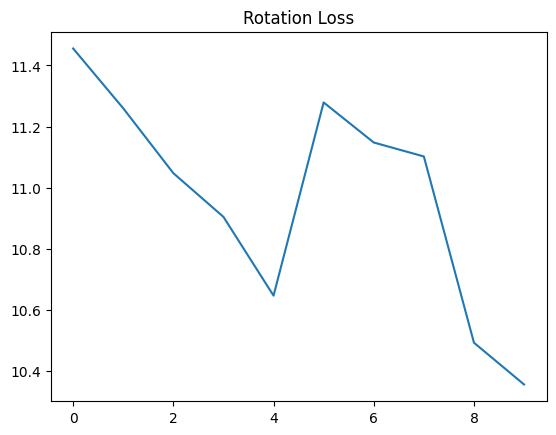

In [8]:
train_losses = []

print(f"Training Rotation Model on {DEVICE}...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for x_base in train_loader:
        x_base = x_base.to(DEVICE)
        B = x_base.shape[0]
        
        ang_start = torch.rand(B, device=DEVICE) * 360
        ang_delta = torch.rand(B, device=DEVICE) * 360 - 180 # -180 to 180
        
        # Generate gt frames
        x0 = K.rotate(x_base, ang_start)
        x1 = K.rotate(x_base, ang_start + ang_delta)
        
        t = torch.rand(B, 1, device=DEVICE)
        t_view = t.view(B, 1, 1, 1)
        
        # Linear Interp for now (Simpler for pure rotation learning)
        ang_t = ang_start + (t.squeeze() * ang_delta)
        x_t = K.rotate(x_base, ang_t)
        
        # Target Velocity: Tangent at current angle
        dt = 0.1
        x_next = K.rotate(x_base, ang_t + (dt * ang_delta))
        target_v = (x_next - x_t) / dt
        
        # We explicitly condition on ang_delta so model knows direction/magnitude
        pred_v = model(x_t, t, x0, ang_delta.view(B, 1))
        
        loss = F.mse_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    avg = epoch_loss / len(train_loader)
    train_losses.append(avg)
    if (epoch+1) % 5 == 0: print(f"Epoch {epoch+1}: {avg:.5f}")

plt.plot(train_losses); plt.title("Rotation Loss"); plt.show()

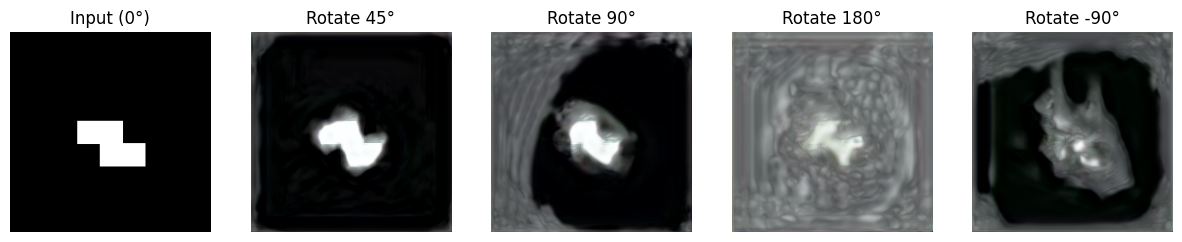

In [7]:
@torch.no_grad()
def apply_rotation(model, x_input, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = x_input.clone()
    B = x_input.shape[0]
    
    target_ang_tensor = torch.full((B, 1), angle_deg, device=DEVICE)
    
    for i in range(steps):
        t = torch.full((B, 1), i/steps, device=DEVICE)
        v = model(curr, t, x_input, target_ang_tensor)
        curr = curr + v * dt
        
    return curr

# Visualize
x_sample = next(iter(test_loader))[0:1].to(DEVICE)
angles_to_test = [45, 90, 180, -90]

fig, axes = plt.subplots(1, len(angles_to_test) + 1, figsize=(15, 3))

# Show Input
def show(ax, t, title):
    img = t[0].permute(1,2,0).cpu().numpy()
    img = (img * 0.229) + 0.485
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis('off')

show(axes[0], x_sample, "Input (0°)")

for i, ang in enumerate(angles_to_test):
    x_rot = apply_rotation(model, x_sample, float(ang))
    show(axes[i+1], x_rot, f"Rotate {ang}°")

plt.show()